In [14]:
from ultralytics import YOLO
import time
import pandas as pd
import shutil
import os
import re
import cv2
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans
import webcolors
from skimage.color import rgb2lab
import numpy as np
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
import webcolors
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights

Necessary functions

In [15]:
def return_Dominant_colors(cluster, C_centroids):
    # Calculate histogram of cluster labels
    C_labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (C_hist, _) = np.histogram(cluster.labels_, bins=C_labels)
    C_hist = C_hist.astype("float")
    C_hist /= C_hist.sum()

    # Create a rectangle to visualize dominant colors
    dict_list = [{} for _ in range(5)]
    img_colors = sorted(
        [(percent, color) for (percent, color) in zip(C_hist, C_centroids)],
        key=lambda x: x[0],
    )
    start = 0
    i = 0
    for (percent, color) in img_colors:
        print(color, "{:0.2f}%".format(percent * 100))
        dict_list[i].update({f'color_{i+1}': numpy_array_to_string(color), f'color_{i+1}_percent': "{:0.2f}%".format(percent * 100)})
        end = start + (percent * 300)
        start = end
        i += 1
    return dict_list

def crop_cat(img_path):
    model = YOLO("yolov8m-seg.pt")
    results = model.predict(img_path, classes=15)
    result = results[0]

    masks = result.masks
    if(result.masks == None):
        return False
    
    # Retrieve segmentation mask and polygon
    mask1 = masks[0]
    mask = mask1.cpu().data[0].numpy()
    polygon = mask1.xy[0]

    # Open the input image
    im = Image.open(img_path).convert("RGBA")
    imArray = np.asarray(im)

    # Create a binary mask image
    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
    mask_ = np.array(maskIm)

    # Create a new RGBA image with the detected object in color and the background transparent
    newImArray = np.empty(imArray.shape,dtype='uint8')
    newImArray[:,:,:3] = imArray[:,:,:3]
    newImArray[:,:,3] = mask_*255
    newIm = Image.fromarray(newImArray, "RGBA")
    newIm.save("./img/out.png")
    return True

def rgb_to_lab(rgb_color):
    # Convert RGB to CIELAB
    lab_color = rgb2lab(np.uint8([[rgb_color]]))
    return lab_color[0, 0]

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        color1_lab = rgb_to_lab([r_c, g_c, b_c])
        color2_lab = rgb_to_lab(requested_colour)
        
        # Compute Euclidean distance in CIELAB space
        distance = sum((c1 - c2) ** 2 for c1, c2 in zip(color1_lab, color2_lab)) ** 0.5

        min_colours[distance] = name
    return min_colours[min(min_colours.keys())]

def color_similarity_lab(color1, color2):
    # Compute Euclidean distance in CIELAB space
    delta_L = color1[0] - color2[0]
    delta_a = color1[1] - color2[1]
    delta_b = color1[2] - color2[2]
    
    distance = (delta_L**2 + delta_a**2 + delta_b**2)**0.5
    return distance

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return closest_name

def string_to_numpy_array(string):
    return np.fromstring(string[1:-1], sep=',')

def numpy_array_to_string(array):
    return np.array2string(array.astype(int), separator=', ')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_rotation = torchvision.transforms.RandomApply([
    torchvision.transforms.RandomRotation(20)
], p=0.2)

class ModelHead(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes):
        super(ModelHead, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_dim // 2, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

MODEL_SAVE_PATH = './checkpoints'

Retrive images from user first

#### Video Capturing and Cropping Cats using YOLOv8
This is assuming that we have the cat feeding harware with camera in it.

This code deletes exising folders because we would like to save space.

Then, it reads Dataframe created by YOLO model, track(). It drops any annotations because we are not using it.

In [17]:
location = "./img/predict/"
dir_1 = "crops"
dir_2 = "labels"
path_1 = os.path.join(location, dir_1)
path_2 = os.path.join(location, dir_2)

if os.path.exists(path_1):
    shutil.rmtree(path_1) 
if os.path.exists(path_2):
    shutil.rmtree(path_2) 

model = YOLO("yolo-Weights/yolov8x.pt")
model.to('cuda')

video_path = "./data/cat.mp4"
cap = cv2.VideoCapture(video_path)

t_end = time.time() + 120 # for 2min
ret = True
count = 0

while ret and time.time() < t_end:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, show=True, save_txt=True, save_crop=True, project="img", exist_ok=True, augment=True, classes=15)
    frame_ = results[0].plot()
    print(results)

    count += 10  # Increment frame count

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    # Set the next frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)

cap.release()
cv2.destroyAllWindows()


0: 640x512 2 cats, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: '

Speed: 2.0ms preprocess, 160.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'ap

Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant'

0: 640x512 2 cats, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'b

Speed: 2.0ms preprocess, 161.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'ap

Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant'

0: 640x512 2 cats, 162.0ms
Speed: 3.0ms preprocess, 162.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'b

Speed: 2.0ms preprocess, 163.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'ap

Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant'

0: 640x512 2 cats, 165.0ms
Speed: 2.0ms preprocess, 165.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'b

Speed: 2.0ms preprocess, 165.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 512)
Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'ap

Results saved to img\predict
1 label saved to img\predict\labels
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant'

In [25]:
for filename in os.listdir("./img/predict/crops/cat/"): # delete existing id splitted folders
    match = re.match("id_" + r'[0-9]+', filename)
    if match:
        shutil.rmtree(os.path.join(source_directory, match.string))

df_path = "./img/predict/labels/image0.txt" # df_main
img_file_path = "./img/predict/crops/cat/image" # where cropped images are stored

if os.path.exists(f"{img_file_path}0.jpg"): # Rename the first image file if it exists
    os.rename(f"{img_file_path}0.jpg", f"{img_file_path}01.jpg")

# Read the Main_df into a DataFrame
df = pd.read_csv(df_path, sep=' ', header=None, names=['class', 'x1', 'y1', 'x2', 'y2', 'id'])
num_of_cats = df['id'].max()
df.drop(columns = ['x1', 'y1', 'x2', 'y2'], inplace = True) # I am not smart enough to use those annotations.
df.index += 1
df['img_num'] = df.index
df.to_csv(df_path, sep=' ', header=True, index=True) # index number is same as file number

# this is necessary because YOLO distinguishes multiple objects by ID and we want to make use of that.

In [26]:
df

,class,id,img_num
1,15,1,1
2,15,2,2
3,15,1,3
4,15,2,4
5,15,1,5
...,...,...,...
95,15,2,95
96,15,1,96
97,15,2,97
98,15,1,98


---

#### Color detection

In [27]:
# reset df
df_path = "./img/predict/labels/image0.txt"
df = pd.read_csv(df_path, sep=' ', header=0, names=['class', 'id', 'img_num'])
num_of_cats = df['id'].max()
df

,class,id,img_num
1,15,1,1
2,15,2,2
3,15,1,3
4,15,2,4
5,15,1,5
...,...,...,...
95,15,2,95
96,15,1,96
97,15,2,97
98,15,1,98


In [28]:
path = "./img/predict/crops/cat/"
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
imgs_list = [filename for filename in os.listdir(path) if os.path.splitext(filename)[-1] in image_extensions]

for img in imgs_list:
    img_num = img[6:].replace('.jpg', "")
    
    if (crop_cat(path + img)):
        # Load the resulting image
        src_image = cv2.imread("./img/out.png")
        src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
        reshape_img = src_image.reshape((src_image.shape[0] * src_image.shape[1], 3))

        # Apply K-Means clustering to identify dominant colors
        KM_cluster = KMeans(n_clusters=5, n_init=10).fit(reshape_img)
        colors = return_Dominant_colors(KM_cluster, KM_cluster.cluster_centers_)
        
        k = 0
        for l in colors:
            values = list(l.values())
            df.loc[df[df["img_num"] == int(img_num)].index.tolist()[0], f"color_{k + 1}"] = values[0]
            k += 1
        print(df.loc[df["img_num"] == int(img_num)])
        cv2.destroyAllWindows()
    else:
        k = 0
        for l in range(5):
            df.loc[df[df["img_num"] == int(img_num)].index.tolist()[0], f"color_{k + 1}"] = np.NaN
            k += 1
        print(df.loc[df["img_num"] == int(img_num)])
        cv2.destroyAllWindows()
        
# df.to_csv(df_path, sep=' ', header=True, index=False)


image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image01.jpg: 640x512 1 cat, 40.0ms
Speed: 3.0ms preprocess, 40.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
[     182.65      157.36      132.35] 12.64%
[     212.21      198.83      182.82] 14.49%
[     133.63      99.603      70.939] 21.29%
[     164.98       124.2      86.896] 24.27%
[      99.21      72.393      52.071] 27.32%
   class  id  img_num          color_1          color_2          color_3  \
1     15   1        1  [182, 157, 132]  [212, 198, 182]  [133,  99,  70]   

           color_4       color_5  
1  [164, 124,  86]  [99, 72, 52]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image010.jpg: 640x416 2 cats, 35.0ms
Speed: 1.0ms preprocess, 35.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)
[      207.8      215.25      222.61] 7.93%
[     151.28      147.36      144.63] 11.2


image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image020.jpg: 640x384 1 cat, 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)
[     207.88      215.54      223.74] 7.91%
[     147.42      145.58      146.41] 9.62%
[     24.225      24.735      25.222] 23.31%
[     110.86      98.316      87.456] 24.55%
[      68.47      59.812      54.026] 34.61%
    class  id  img_num          color_1          color_2       color_3  \
20     15   1       20  [207, 215, 223]  [147, 145, 146]  [24, 24, 25]   

            color_4       color_5  
20  [110,  98,  87]  [68, 59, 54]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image021.jpg: 640x512 3 cats, 81.0ms
Speed: 3.0ms preprocess, 81.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 512)
[     180.66      156.61      134.03] 11.60%
[     212.56      198.44       182.2] 12.96%


image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image032.jpg: 640x352 1 cat, 45.0ms
Speed: 2.0ms preprocess, 45.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 352)
[     201.56      193.54      188.18] 8.22%
[     145.54      144.27      145.13] 15.72%
[     27.263      27.313      26.802] 19.25%
[     105.25      95.565      88.265] 24.47%
[     66.995      59.511      54.475] 32.35%
    class  id  img_num          color_1          color_2       color_3  \
32     15   1       32  [201, 193, 188]  [145, 144, 145]  [27, 27, 26]   

            color_4       color_5  
32  [105,  95,  88]  [66, 59, 54]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image033.jpg: 640x480 3 cats, 31.0ms
Speed: 1.0ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
[     177.25      156.18      135.56] 10.95%
[     219.16      204.96      186.88] 13.35

Speed: 2.0ms preprocess, 36.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 512)
[     180.73       159.5      138.91] 11.58%
[     214.58         202      187.64] 14.46%
[     163.11       124.6      90.329] 21.79%
[     98.887      74.082      55.347] 22.05%
[     132.15      97.102      69.776] 30.12%
    class  id  img_num          color_1          color_2          color_3  \
43     15   2       43  [180, 159, 138]  [214, 201, 187]  [163, 124,  90]   

         color_4          color_5  
43  [98, 74, 55]  [132,  97,  69]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image044.jpg: 640x352 2 cats, 31.0ms
Speed: 1.0ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 352)
[     196.39      200.95      206.08] 12.76%
[     145.78      144.74      147.24] 13.95%
[      23.57      23.961      24.511] 18.92%
[     100.97      95.333      92.208] 20.95%
[     65.106      60.466      57.707]


image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image055.jpg: 640x512 3 cats, 36.0ms
Speed: 1.0ms preprocess, 36.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 512)
[     179.83      158.24      138.27] 11.97%
[     209.72      198.26      185.73] 14.90%
[     97.382      73.797      56.698] 19.41%
[      162.3      124.83       91.34] 23.82%
[     130.18      96.983      71.877] 29.89%
    class  id  img_num          color_1          color_2       color_3  \
55     15   2       55  [179, 158, 138]  [209, 198, 185]  [97, 73, 56]   

            color_4          color_5  
55  [162, 124,  91]  [130,  96,  71]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image056.jpg: 640x352 1 cat, 38.0ms
Speed: 1.0ms preprocess, 38.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 352)
[      199.9      208.81      217.62] 10.37%
[     148.38      144.86      144.25


image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image067.jpg: 640x512 3 cats, 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 512)
[     187.58      162.73      139.32] 11.69%
[      222.5      208.07      192.15] 14.38%
[     103.53      75.931      55.752] 20.05%
[     169.45      127.01      90.096] 24.22%
[     135.97      98.576      70.283] 29.66%
    class  id  img_num          color_1          color_2          color_3  \
67     15   2       67  [187, 162, 139]  [222, 208, 192]  [103,  75,  55]   

            color_4          color_5  
67  [169, 127,  90]  [135,  98,  70]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image068.jpg: 640x512 3 cats, 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 512)
[        185       160.6      137.29] 11.67%
[     220.86      207.75     


image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image079.jpg: 640x512 3 cats, 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 512)
[     181.18      161.92      142.93] 12.96%
[     216.63      207.84      196.54] 14.84%
[     96.731      75.339      59.207] 17.92%
[     164.38      128.03      95.487] 24.99%
[     129.83      98.458      74.149] 29.29%
    class  id  img_num          color_1          color_2       color_3  \
79     15   2       79  [181, 161, 142]  [216, 207, 196]  [96, 75, 59]   

            color_4          color_5  
79  [164, 128,  95]  [129,  98,  74]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image08.jpg: 640x416 1 cat, 39.0ms
Speed: 1.0ms preprocess, 39.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)
[     207.15      214.93      222.26] 8.53%
[     153.12      149.92      147.76] 


image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image09.jpg: 640x512 3 cats, 37.0ms
Speed: 2.0ms preprocess, 37.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)
[     181.63      158.27      136.18] 12.15%
[     212.91      199.64      183.96] 13.75%
[     165.32      125.39      89.275] 21.16%
[     102.54      75.265        54.3] 25.91%
[      133.5      98.757      70.882] 27.04%
   class  id  img_num          color_1          color_2          color_3  \
9     15   1        9  [181, 158, 136]  [212, 199, 183]  [165, 125,  89]   

           color_4          color_5  
9  [102,  75,  54]  [133,  98,  70]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\img\predict\crops\cat\image090.jpg: 640x352 1 cat, 31.0ms
Speed: 1.0ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 352)
[     152.68      149.27      148.21] 12.51%
[     206.37      208.25      210.6

In [29]:
df

,class,id,img_num,color_1,color_2,color_3,color_4,color_5
1,15,1,1,"[182, 157, 132]","[212, 198, 182]","[133, 99, 70]","[164, 124, 86]","[99, 72, 52]"
2,15,2,2,"[204, 215, 224]","[149, 147, 146]","[22, 23, 23]","[107, 97, 87]","[65, 57, 51]"
3,15,1,3,"[224, 215, 206]","[198, 180, 160]","[171, 137, 105]","[146, 107, 74]","[103, 75, 55]"
4,15,2,4,"[204, 215, 225]","[151, 148, 147]","[22, 23, 23]","[109, 98, 88]","[66, 58, 52]"
5,15,1,5,"[224, 216, 206]","[199, 182, 162]","[172, 138, 107]","[146, 107, 74]","[104, 77, 56]"
...,...,...,...,...,...,...,...,...
95,15,2,95,"[186, 161, 138]","[220, 206, 190]","[100, 74, 55]","[169, 127, 90]","[133, 97, 70]"
96,15,1,96,"[185, 160, 137]","[219, 206, 189]","[100, 74, 56]","[169, 127, 90]","[134, 98, 70]"
97,15,2,97,"[156, 152, 151]","[208, 207, 209]","[112, 104, 98]","[27, 26, 27]","[74, 65, 60]"
98,15,1,98,"[155, 151, 150]","[206, 207, 209]","[26, 26, 26]","[108, 98, 92]","[72, 64, 59]"


In [38]:
df['CIELAB'] = np.nan
for index, row in df.iterrows():
    df.at[index, 'CIELAB'] = numpy_array_to_string(rgb_to_lab(string_to_numpy_array(df.iat[index, 7])))

In [39]:
df

,img_num,class,id,color_1,color_2,color_3,color_4,color_5,CIELAB
0,1,15,1,"[182, 157, 132]","[212, 198, 182]","[133, 99, 70]","[164, 124, 86]","[99, 72, 52]","[32, 8, 16]"
1,2,15,2,"[204, 215, 224]","[149, 147, 146]","[22, 23, 23]","[107, 97, 87]","[65, 57, 51]","[24, 2, 5]"
2,3,15,1,"[224, 215, 206]","[198, 180, 160]","[171, 137, 105]","[146, 107, 74]","[103, 75, 55]","[34, 9, 16]"
3,4,15,2,"[204, 215, 225]","[151, 148, 147]","[22, 23, 23]","[109, 98, 88]","[66, 58, 52]","[25, 2, 5]"
4,5,15,1,"[224, 216, 206]","[199, 182, 162]","[172, 138, 107]","[146, 107, 74]","[104, 77, 56]","[35, 8, 16]"
...,...,...,...,...,...,...,...,...,...
90,95,15,2,"[186, 161, 138]","[220, 206, 190]","[100, 74, 55]","[169, 127, 90]","[133, 97, 70]","[44, 11, 21]"
91,96,15,1,"[185, 160, 137]","[219, 206, 189]","[100, 74, 56]","[169, 127, 90]","[134, 98, 70]","[44, 10, 21]"
92,97,15,2,"[156, 152, 151]","[208, 207, 209]","[112, 104, 98]","[27, 26, 27]","[74, 65, 60]","[28, 2, 4]"
93,98,15,1,"[155, 151, 150]","[206, 207, 209]","[26, 26, 26]","[108, 98, 92]","[72, 64, 59]","[27, 2, 4]"


In [45]:
# remove unecessary data
df = df[['img_num', 'class', 'id', 'color_1', 'color_2', 'color_3', 'color_4', 'color_5', 'CIELAB']]
nalist = df[df.isna().any(axis=1)].index.tolist()
for i in nalist:
    os.remove(f"{path}image0{i}.jpg")
    print(f"Removed: {path}image0{i}.jpg")
df = df.dropna()
df.reset_index(drop=True, inplace = True)

In [46]:
df

,img_num,class,id,color_1,color_2,color_3,color_4,color_5,CIELAB
0,1,15,1,"[182, 157, 132]","[212, 198, 182]","[133, 99, 70]","[164, 124, 86]","[99, 72, 52]","[32, 8, 16]"
1,2,15,2,"[204, 215, 224]","[149, 147, 146]","[22, 23, 23]","[107, 97, 87]","[65, 57, 51]","[24, 2, 5]"
2,3,15,1,"[224, 215, 206]","[198, 180, 160]","[171, 137, 105]","[146, 107, 74]","[103, 75, 55]","[34, 9, 16]"
3,4,15,2,"[204, 215, 225]","[151, 148, 147]","[22, 23, 23]","[109, 98, 88]","[66, 58, 52]","[25, 2, 5]"
4,5,15,1,"[224, 216, 206]","[199, 182, 162]","[172, 138, 107]","[146, 107, 74]","[104, 77, 56]","[35, 8, 16]"
...,...,...,...,...,...,...,...,...,...
90,95,15,1,"[186, 161, 138]","[220, 206, 190]","[100, 74, 55]","[169, 127, 90]","[133, 97, 70]","[44, 11, 21]"
91,96,15,1,"[185, 160, 137]","[219, 206, 189]","[100, 74, 56]","[169, 127, 90]","[134, 98, 70]","[44, 10, 21]"
92,97,15,2,"[156, 152, 151]","[208, 207, 209]","[112, 104, 98]","[27, 26, 27]","[74, 65, 60]","[28, 2, 4]"
93,98,15,2,"[155, 151, 150]","[206, 207, 209]","[26, 26, 26]","[108, 98, 92]","[72, 64, 59]","[27, 2, 4]"


In [47]:
# Compare Colors for every data.
for i in range(num_of_cats):
    lab_color1 = string_to_numpy_array(df[df['id']==i+1].sample(n=1).iat[0, 7])
    for j in range(len(df)):
        lab_color2 = string_to_numpy_array(df.iloc[j, 7])
        similarity = color_similarity_lab(lab_color1, lab_color2)
        if similarity < 11:
            df.iloc[j, 2] = i+1
df

,img_num,class,id,color_1,color_2,color_3,color_4,color_5,CIELAB
0,1,15,1,"[182, 157, 132]","[212, 198, 182]","[133, 99, 70]","[164, 124, 86]","[99, 72, 52]","[32, 8, 16]"
1,2,15,2,"[204, 215, 224]","[149, 147, 146]","[22, 23, 23]","[107, 97, 87]","[65, 57, 51]","[24, 2, 5]"
2,3,15,1,"[224, 215, 206]","[198, 180, 160]","[171, 137, 105]","[146, 107, 74]","[103, 75, 55]","[34, 9, 16]"
3,4,15,2,"[204, 215, 225]","[151, 148, 147]","[22, 23, 23]","[109, 98, 88]","[66, 58, 52]","[25, 2, 5]"
4,5,15,1,"[224, 216, 206]","[199, 182, 162]","[172, 138, 107]","[146, 107, 74]","[104, 77, 56]","[35, 8, 16]"
...,...,...,...,...,...,...,...,...,...
90,95,15,1,"[186, 161, 138]","[220, 206, 190]","[100, 74, 55]","[169, 127, 90]","[133, 97, 70]","[44, 11, 21]"
91,96,15,1,"[185, 160, 137]","[219, 206, 189]","[100, 74, 56]","[169, 127, 90]","[134, 98, 70]","[44, 10, 21]"
92,97,15,2,"[156, 152, 151]","[208, 207, 209]","[112, 104, 98]","[27, 26, 27]","[74, 65, 60]","[28, 2, 4]"
93,98,15,2,"[155, 151, 150]","[206, 207, 209]","[26, 26, 26]","[108, 98, 92]","[72, 64, 59]","[27, 2, 4]"


In [48]:
# Create folders for each 'id'
for i in range(1, int(df['id'].max()) + 1):
    os.makedirs(f"./img/predict/crops/cat/id_{i}", exist_ok=True)

# Move image files to corresponding 'id' folders
for index, row in df.iterrows():
    file_number = row['img_num']
    source_path = f"{img_file_path}0{file_number}.jpg"
    destination_path = f"img/predict/crops/cat/id_{int(row['id'])}"

    shutil.move(source_path, destination_path, copy_function=shutil.copytree)

In [49]:
# Create a dictionary of updated DataFrames. 
dfs = {f"df_{i}": df.loc[df['id'] == i].copy() for i in range(1, int(df['id'].max()) + 1)}

# Print the created DataFrames
for name, df_part in dfs.items():
    print(f"{name}:\n{df_part}\n")
    df_part.to_csv("./img/predict/labels/" + name + ".csv", sep=' ', header=True, index=False)

df_1:
    img_num  class  id          color_1          color_2          color_3  \
0         1     15   1  [182, 157, 132]  [212, 198, 182]  [133,  99,  70]   
2         3     15   1  [224, 215, 206]  [198, 180, 160]  [171, 137, 105]   
4         5     15   1  [224, 216, 206]  [199, 182, 162]  [172, 138, 107]   
6         7     15   1  [181, 157, 135]  [213, 199, 183]  [166, 125,  89]   
8         9     15   1  [181, 158, 136]  [212, 199, 183]  [165, 125,  89]   
10       11     15   1  [182, 158, 136]  [213, 199, 183]  [164, 125,  89]   
12       13     15   1  [181, 157, 134]  [213, 199, 182]  [163, 123,  88]   
13       14     15   1  [179, 154, 131]  [212, 198, 181]  [162, 121,  85]   
15       16     15   1  [180, 155, 133]  [212, 198, 182]  [164, 123,  86]   
17       18     15   1  [179, 155, 132]  [212, 198, 182]  [163, 123,  86]   
20       21     15   1  [180, 156, 134]  [212, 198, 182]  [162, 123,  87]   
22       23     15   1  [181, 158, 135]  [212, 198, 182]  [162, 124,  

---

#### Breed Detection

In [50]:
if __name__ == '__main__':
    print(f'Using device: {device}.')

    model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.fc = ModelHead(2048, 1024, 12)
    model.fc.to(device)

    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_checkpoint.pth')))
    model.eval()
    
    transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
    class_labels = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx'] 
    
    # df = pd.read_csv("./img/predict/labels/image0.txt", sep=' ', header=0, names=['img_num', 'class', 'id', 'Dominant Color', 'CIELAB Color'])
    num_of_cats = df['id'].max()

    for i in range(num_of_cats):
        img_path = f"./img/predict/crops/cat/id_{i + 1}"
        imgs_list = [filename for filename in os.listdir(img_path) if os.path.splitext(filename)[-1] in image_extensions]

        df_id = pd.read_csv(f"./img/predict/labels/df_{i + 1}.csv", sep=' ', header=0)

        for img in imgs_list:
            image = Image.open(os.path.join(img_path, img))
            img_num = img[6:].replace('.jpg', "")
            
            preprocessed_image = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                predictions = model(preprocessed_image)

            predicted_class = torch.argmax(predictions).item()

            predicted_label = class_labels[predicted_class]
            print(f'Predicted class: {predicted_label}')

            df_id.loc[df_id["img_num"] == int(img_num), "breed"] = predicted_label
            print(print(df_id.loc[df_id["img_num"] == int(img_num)]))

        print(df_id)
        df_id.to_csv(f"./img/predict/labels/df_{i + 1}.csv", sep=' ', header=True, index=False)

Using device: cuda.
Predicted class: Persian
   img_num  class  id          color_1          color_2          color_3  \
0        1     15   1  [182, 157, 132]  [212, 198, 182]  [133,  99,  70]   

           color_4       color_5        CIELAB    breed  
0  [164, 124,  86]  [99, 72, 52]  [32,  8, 16]  Persian  
None
Predicted class: Persian
   img_num  class  id          color_1          color_2          color_3  \
5       11     15   1  [182, 158, 136]  [213, 199, 183]  [164, 125,  89]   

           color_4          color_5        CIELAB    breed  
5  [101,  74,  53]  [133,  98,  70]  [44, 10, 21]  Persian  
None
Predicted class: Persian
   img_num  class  id          color_1          color_2          color_3  \
6       13     15   1  [181, 157, 134]  [213, 199, 182]  [163, 123,  88]   

           color_4          color_5        CIELAB    breed  
6  [100,  73,  53]  [132,  97,  69]  [44, 10, 21]  Persian  
None
Predicted class: Persian
   img_num  class  id          color_1        

Predicted class: Persian
    img_num  class  id          color_1          color_2       color_3  \
29       70     15   1  [183, 160, 137]  [219, 207, 193]  [99, 75, 57]   

            color_4          color_5        CIELAB    breed  
29  [167, 127,  90]  [133,  98,  70]  [44, 10, 21]  Persian  
None
Predicted class: Persian
    img_num  class  id          color_1          color_2          color_3  \
30       73     15   1  [183, 161, 141]  [218, 207, 194]  [100,  75,  58]   

            color_4          color_5        CIELAB    breed  
30  [166, 127,  92]  [133,  98,  72]  [44, 10, 20]  Persian  
None
Predicted class: Persian
    img_num  class  id          color_1          color_2       color_3  \
31       74     15   1  [182, 160, 140]  [217, 207, 194]  [97, 74, 58]   

            color_4          color_5        CIELAB    breed  
31  [165, 127,  93]  [130,  97,  72]  [43,  9, 19]  Persian  
None
Predicted class: Persian
    img_num  class  id          color_1          color_2    

Predicted class: Persian
    img_num  class  id          color_1          color_2       color_3  \
12       31     15   2  [175, 155, 134]  [218, 204, 186]  [97, 69, 48]   

            color_4          color_5        CIELAB    breed  
12  [153, 113,  78]  [125,  91,  64]  [41, 10, 21]  Persian  
None
Predicted class: British Shorthair
    img_num  class  id          color_1          color_2       color_3  \
13       32     15   2  [201, 193, 188]  [145, 144, 145]  [27, 27, 26]   

            color_4       color_5        CIELAB              breed  
13  [105,  95,  88]  [66, 59, 54]  [25,  2,  4]  British Shorthair  
None
Predicted class: Persian
    img_num  class  id          color_1          color_2       color_3  \
14       33     15   2  [177, 156, 135]  [219, 204, 186]  [91, 66, 48]   

            color_4          color_5        CIELAB    breed  
14  [154, 113,  78]  [122,  88,  62]  [40, 10, 20]  Persian  
None
Predicted class: British Shorthair
    img_num  class  id          

Predicted class: British Shorthair
    img_num  class  id          color_1          color_2       color_3  \
43       90     15   2  [152, 149, 148]  [206, 208, 210]  [25, 24, 25]   

            color_4       color_5        CIELAB              breed  
43  [106,  97,  89]  [71, 63, 58]  [27,  2,  4]  British Shorthair  
None
Predicted class: Persian
    img_num  class  id          color_1          color_2       color_3  \
44       92     15   2  [150, 147, 146]  [206, 208, 211]  [25, 24, 24]   

            color_4       color_5        CIELAB    breed  
44  [109,  96,  87]  [71, 62, 57]  [26,  2,  4]  Persian  
None
Predicted class: British Shorthair
    img_num  class  id          color_1          color_2          color_3  \
45       94     15   2  [155, 151, 150]  [206, 207, 209]  [109, 100,  94]   

         color_4       color_5        CIELAB              breed  
45  [26, 25, 26]  [72, 64, 59]  [27,  2,  4]  British Shorthair  
None
Predicted class: British Shorthair
    img_num  c

In [51]:
# file organization
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
for i in range(num_of_cats):
    img_path = f"./img/predict/crops/cat/id_{i + 1}"
    imgs_list = [filename for filename in os.listdir(img_path) if os.path.splitext(filename)[-1] in image_extensions]
    if(len(imgs_list)<10):
        os.remove(f"./img/predict/labels/df_{i + 1}.csv")
        shutil.rmtree(f'./img/predict/crops/cat/id_{i + 1}')

In [55]:
source_folder = './img/predict/labels'
destination_folder = 'C:/Users/sento/Documents/Python/notebook/catFeeder/AI/API/labels'

# Check if the destination folder already exists
if not os.path.exists(destination_folder):
    # Copy the entire folder from source to destination
    shutil.copytree(source_folder, destination_folder)
else:
    print(f"The destination folder '{destination_folder}' already exists.")
    # Handle this case as needed

The destination folder 'C:/Users/sento/Documents/Python/notebook/catFeeder/AI/API/labels' already exists.


---

### Image processing from user

comfirming this is a cat using YOLO model

In [56]:
model = YOLO("yolo-Weights/yolov8x.pt")
model.to('cuda')
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

dir_path= './photosForAI/'
num_of_cats = len(next(os.walk(dir_path))[1])

for i in range(num_of_cats):
    path = f'./photosForAI/catId_{i + 1}/images/'

    path_ = (f'./photosForAI/catId_{i + 1}/predict')
    if os.path.exists(path_):
        shutil.rmtree(path_)
    
    imgs_list = [filename for filename in os.listdir(path) if os.path.splitext(filename)[-1] in image_extensions]
    for image in imgs_list:
        results = model.predict(path + image, show=False, save_txt=True, project=dir_path + f'/catId_{i + 1}', exist_ok=True, augment=True, classes=15)
    
    #list all the files from the directory
    file_list = os.listdir(f'./photosForAI/catId_{i + 1}/predict/labels/')
    df_concat = pd.concat([pd.read_csv(f'./photosForAI/catId_{i + 1}/predict/labels/' + f, header=None, sep=' ', names=['class', 'x1', 'y1', 'x2', 'y2']) for f in file_list], ignore_index=True)
    
    df_concat['file_name'] = imgs_list

    df_concat.to_csv(f'./photosForAI/catId_{i + 1}.csv', sep=' ', header=True, index=False)


image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\photosForAI\catId_1\images\image0115.jpg: 640x576 1 cat, 497.0ms
Speed: 34.0ms preprocess, 497.0ms inference, 50.0ms postprocess per image at shape (1, 3, 640, 576)
Results saved to photosForAI\catId_1\predict
1 label saved to photosForAI\catId_1\predict\labels

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\photosForAI\catId_1\images\image0186.jpg: 640x640 1 cat, 474.0ms
Speed: 5.0ms preprocess, 474.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to photosForAI\catId_1\predict
2 labels saved to photosForAI\catId_1\predict\labels

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\photosForAI\catId_1\images\image0216.jpg: 640x640 1 cat, 473.0ms
Speed: 5.0ms preprocess, 473.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to photosForAI\catId_1\predict
3 labels saved to photosForAI\catId

breed detection

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}.')

transform_rotation = torchvision.transforms.RandomApply([
    torchvision.transforms.RandomRotation(20)
], p=0.2)

MODEL_SAVE_PATH = './checkpoints'
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

for parameter in model.parameters():
    parameter.requires_grad = False

model.fc = ModelHead(2048, 1024, 12)
model.fc.to(device)

model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_checkpoint.pth')))
model.eval()

for i in range(num_of_cats):
    img_path = f"./photosForAI/catId_{i + 1}/images"
    imgs_list = [filename for filename in os.listdir(img_path) if os.path.splitext(filename)[-1] in image_extensions]

    print("\n\n-------------------------------------------------------")
    print(img_path)
    
    df_id = pd.read_csv(f"./photosForAI/catId_{i + 1}.csv", sep=' ', header=0)
    df_id.drop(columns=['x1', 'y1', 'x2', 'y2'], inplace=True)
    for img in imgs_list:
        image = Image.open(os.path.join(img_path, img))

        img_num = img[6:].replace('.jpg', "")
        
        preprocessed_image = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            predictions = model(preprocessed_image)
        
        predicted_class = torch.argmax(predictions).item()
        
        class_labels = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx'] 
        predicted_label = class_labels[predicted_class]
        print(f'Predicted class: {predicted_label}', predicted_class)
        
        df_id.loc[df_id[df_id["file_name"] == img].index.tolist(), "breed"] = predicted_label
        print(df_id.loc[df_id["file_name"] == img])
        
        df_id.to_csv(f"./photosForAI/catId_{i + 1}.csv", sep=' ', header=True, index=False)

Using device: cuda.


-------------------------------------------------------
./photosForAI/catId_1/images
Predicted class: British Shorthair 4
   class      file_name              breed
0     15  image0115.jpg  British Shorthair
Predicted class: British Shorthair 4
   class      file_name              breed
1     15  image0186.jpg  British Shorthair
Predicted class: British Shorthair 4
   class      file_name              breed
2     15  image0216.jpg  British Shorthair
Predicted class: British Shorthair 4
   class      file_name              breed
3     15  image0342.jpg  British Shorthair
Predicted class: British Shorthair 4
   class     file_name              breed
4     15  image090.jpg  British Shorthair


-------------------------------------------------------
./photosForAI/catId_2/images
Predicted class: Persian 7
   class     file_name    breed
0     15  image014.jpg  Persian
Predicted class: Persian 7
   class     file_name    breed
1     15  image022.jpg  Persian
Predicted c

In [59]:
a = pd.read_csv('./photosForAI/catId_1.csv', sep=' ', header=0)
a

,class,file_name,breed
0,15,image0115.jpg,British Shorthair
1,15,image0186.jpg,British Shorthair
2,15,image0216.jpg,British Shorthair
3,15,image0342.jpg,British Shorthair
4,15,image090.jpg,British Shorthair


In [60]:
b = pd.read_csv('./photosForAI/catId_2.csv', sep=' ', header=0)
b

,class,file_name,breed
0,15,image014.jpg,Persian
1,15,image022.jpg,Persian
2,15,image0317.jpg,Persian
3,15,image05.jpg,Persian
4,15,image051.jpg,Persian


color detection

In [ ]:
img_num = img[6:].replace('.jpg', "")
    
    if (crop_cat(path + img)):
        # Load the resulting image
        src_image = cv2.imread("./img/out.png")
        src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
        reshape_img = src_image.reshape((src_image.shape[0] * src_image.shape[1], 3))

        # Apply K-Means clustering to identify dominant colors
        KM_cluster = KMeans(n_clusters=5, n_init=10).fit(reshape_img)
        colors = return_Dominant_colors(KM_cluster, KM_cluster.cluster_centers_)
        
        k = 0
        for l in colors:
            values = list(l.values())
            df.loc[df[df["img_num"] == int(img_num)].index.tolist()[0], f"color_{k + 1}"] = values[0]
            k += 1
        print(df.loc[df["img_num"] == int(img_num)])
        cv2.destroyAllWindows()
    else:
        k = 0
        for l in range(5):
            df.loc[df[df["img_num"] == int(img_num)].index.tolist()[0], f"color_{k + 1}"] = np.NaN
            k += 1
        print(df.loc[df["img_num"] == int(img_num)])
        cv2.destroyAllWindows()

In [62]:
for i in range(num_of_cats):
    df_id = pd.read_csv(f"./photosForAI/catId_{i + 1}.csv", sep=' ', header=0)
    img_path = f"./photosForAI/catId_{i + 1}/images"
    imgs_list = [filename for filename in os.listdir(img_path) if os.path.splitext(filename)[-1] in image_extensions]

    print("\n\n-------------------------------------------------------")
    print(img_path)

    for img in imgs_list:
        if (crop_cat(img_path + "/" + img)):
            # Load the resulting image
            src_image = cv2.imread("./img/out.png")
            src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
            reshape_img = src_image.reshape((src_image.shape[0] * src_image.shape[1], 3))

            # Apply K-Means clustering to identify dominant colors
            KM_cluster = KMeans(n_clusters=5, n_init=10).fit(reshape_img)
            colors = return_Dominant_colors(KM_cluster, KM_cluster.cluster_centers_)
            k = 0
            for l in colors:
                values = list(l.values())
                df_id.loc[df_id[df_id["file_name"] == img].index.tolist(), f"color_{k + 1}"] = values[0]
                k += 1
            print(df_id.loc[df_id["file_name"] == img])
            cv2.destroyAllWindows()
        else:
            k = 0
            for l in range(5):
                df_id.loc[df_id[df_id["file_name"] == img].index.tolist(), f"color_{k + 1}"] = np.NaN
                k += 1
            print(df_id.loc[df_id["file_name"] == img])
            cv2.destroyAllWindows()
        df_id.to_csv(f"./photosForAI/catId_{i + 1}.csv", sep=' ', header=True, index=False)



-------------------------------------------------------
./photosForAI/catId_1/images

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\photosForAI\catId_1\images\image0115.jpg: 640x576 1 cat, 103.0ms
Speed: 5.0ms preprocess, 103.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 576)
[     226.67         219      220.83] 8.96%
[     95.686      78.099      68.614] 11.19%
[     204.48      176.23      157.54] 23.30%
[     169.15      135.94      113.72] 24.74%
[     29.769      27.339      30.487] 31.81%
   class      file_name              breed          color_1       color_2  \
0     15  image0115.jpg  British Shorthair  [226, 219, 220]  [95, 78, 68]   

           color_3          color_4       color_5  
0  [204, 176, 157]  [169, 135, 113]  [29, 27, 30]  

image 1/1 C:\Users\sento\Documents\Python\notebook\catFeeder\AI\CatFeederSim\photosForAI\catId_1\images\image0186.jpg: 640x640 1 cat, 96.0ms
Speed: 4.0ms preprocess, 96.0ms inference, 3.0m

In [63]:
a = pd.read_csv('./photosForAI/catId_1.csv', sep=' ', header=0)
a

,class,file_name,breed,color_1,color_2,color_3,color_4,color_5
0,15,image0115.jpg,British Shorthair,"[226, 219, 220]","[95, 78, 68]","[204, 176, 157]","[169, 135, 113]","[29, 27, 30]"
1,15,image0186.jpg,British Shorthair,"[104, 80, 65]","[218, 215, 215]","[188, 163, 142]","[24, 21, 19]","[161, 123, 90]"
2,15,image0216.jpg,British Shorthair,"[97, 81, 74]","[209, 192, 184]","[195, 165, 141]","[170, 133, 101]","[35, 32, 32]"
3,15,image0342.jpg,British Shorthair,"[139, 104, 87]","[188, 144, 116]","[126, 135, 140]","[224, 191, 170]","[32, 26, 27]"
4,15,image090.jpg,British Shorthair,"[184, 172, 163]","[118, 82, 54]","[185, 150, 118]","[158, 122, 90]","[33, 30, 28]"


In [64]:
b = pd.read_csv('./photosForAI/catId_2.csv', sep=' ', header=0)
b

,class,file_name,breed,color_1,color_2,color_3,color_4,color_5
0,15,image014.jpg,Persian,"[166, 146, 132]","[192, 179, 170]","[102, 61, 33]","[135, 90, 55]","[159, 114, 77]"
1,15,image022.jpg,Persian,"[204, 171, 146]","[96, 52, 23]","[168, 141, 121]","[136, 87, 51]","[166, 118, 76]"
2,15,image0317.jpg,Persian,"[198, 174, 158]","[220, 212, 214]","[181, 140, 108]","[159, 112, 76]","[72, 72, 81]"
3,15,image05.jpg,Persian,"[206, 187, 175]","[102, 63, 36]","[160, 155, 155]","[167, 126, 92]","[146, 100, 64]"
4,15,image051.jpg,Persian,"[205, 174, 154]","[107, 62, 32]","[170, 143, 127]","[153, 108, 74]","[138, 84, 46]"


---

### Dominant Colors Demonstration 

![cat](./photosForAI/catId_1/images/image0115.jpg)

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

class DominantColors:
  
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    
    def plotClusters(self):
        #plotting 
        fig = plt.figure()
        ax = Axes3D(fig)        
        for label, pix in zip(self.LABELS, self.IMAGE):
            ax.scatter(pix[0], pix[1], pix[2], color = self.rgb_to_hex(self.COLORS[label]))
        plt.show()
    
    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def dominantColors(self):
    
        #read image
        img = cv2.imread(self.IMAGE)
        
        #convert to rgb from bgr
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        kmeans.fit(img)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #returning after converting to integer from float
        return self.COLORS.astype(int)
    
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    
    def plotClusters(self, sample_size=5000):
        # Randomly sample points for plotting
        sampled_indices = np.random.choice(self.IMAGE.shape[0], sample_size, replace=False)
        sampled_pixels = self.IMAGE[sampled_indices]

        # Plotting
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for label, pix in zip(self.LABELS[sampled_indices], sampled_pixels):
            ax.scatter(pix[0], pix[1], pix[2], color=self.rgb_to_hex(self.COLORS[label]))
        plt.show()

        
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

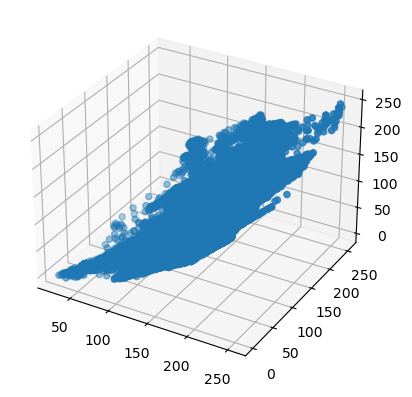

In [12]:
image = cv2.imread('./img/out.png')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the channels and flatten them
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(r, g, b)

# Display the plot
plt.show()

C:\Users\sento\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


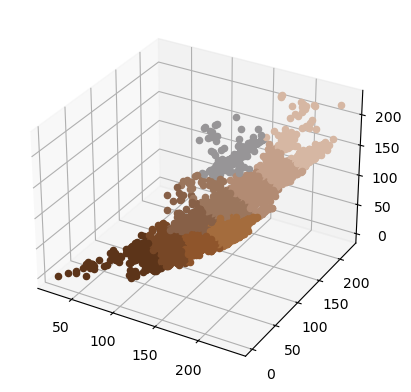

In [19]:
img = './img/out.png'
clusters = 10
dc = DominantColors(img, clusters)
colors = dc.dominantColors()
dc.plotClusters()

C:\Users\sento\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


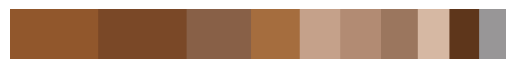

In [18]:
img = './img/out.png'
clusters = 10
dc = DominantColors(img, clusters)
colors = dc.dominantColors()
dc.plotHistogram()

---

#### Comparison with extracted color and breed data

General Algorithm:  
1단계) breed 비교 (breed 다르면 비교 대상에서 제외)  
2단계) color1 비교 (color1 값이 다르면 비교 대상에서 제외)  
3단계) 나머지 color 비교 (남은 고양이 중 subMatch 점수 높은 고양이로 분류하여 return)  

In [24]:
dir_path = './img/predict/crops/cat/'
num_of_cats = len(next(os.walk(dir_path))[1])

AI_dir_path = './photosForAI/'
AI_num_of_cats = len(next(os.walk(AI_dir_path))[1])

for i in range(num_of_cats-1):
    # print(f'df_{i + 1}_new.csv')
    df_path = f'./img/predict/labels/df_{i + 1}.csv'
    df = pd.read_csv(df_path, header=0, sep=' ')
    df = df[['class', 'img_num', 'Dominant Color', 'CIELAB Color', 'breed', 'id']]
    breed = df.iloc[:, 4].value_counts().index[0]
    lab_color1 = string_to_numpy_array(df.iloc[1, 3])
    
    for j in range(AI_num_of_cats):
        # print(f'Id_{j + 1}.csv')
        df_path_ = f'./photosForAI/catId_{j + 1}.csv'
        df_ = pd.read_csv(df_path_, header=0, sep=' ')
        df_ = df_[['class', 'file_name', 'Dominant color', 'CIELAB Color', 'breed']]
        breed_ = df_.iloc[:, 4].value_counts().index[0]
        lab_color2 = string_to_numpy_array(df_.iloc[1, 3])
        similarity = color_similarity_lab(lab_color1, lab_color2)
        
        print(f"df_{i + 1}, catId_{j + 1} color similarity: {similarity}" )
        print(f"Is breed matching?: {breed == breed_} \n")

    print("--------------------------------------------------------------")

df_1, catId_1 color similarity: 32.17141588429082
Is breed matching?: False 

df_1, catId_2 color similarity: 23.93741840717165
Is breed matching?: True 

--------------------------------------------------------------
df_2, catId_1 color similarity: 18.547236990991408
Is breed matching?: True 

df_2, catId_2 color similarity: 39.11521443121589
Is breed matching?: False 

--------------------------------------------------------------


In [110]:
img_dir_path = './img/predict/crops/cat/'
ai_dir_path = './photosForAI/'

# Get the list of cat IDs in the img directory
num_of_cats = len(next(os.walk(img_dir_path))[1])

# Get the list of cat IDs in the AI directory
ai_num_of_cats = len(next(os.walk(ai_dir_path))[1])

results_list = []

for j in range(ai_num_of_cats): # 2
    ai_cat_id_path = os.path.join(ai_dir_path, f'catId_{j + 1}')
    ai_df_path = f'./photosForAI/catId_{j + 1}.csv'
    
    df_ = pd.read_csv(ai_df_path, header=0, sep=' ')
    #breed_ = df_.iloc[j, 0]
    
    for i in range(num_of_cats): # 2
        img_cat_id_path = os.path.join(img_dir_path, f'id_{i + 1}')
        df_path = f'./img/predict/labels/df_{i + 1}.csv'

        df = pd.read_csv(df_path, header=0, sep=' ')
        #breed = df.iloc[i, 0]
        
        for index_, row_ in df_.iterrows():
            breed_ = row_['breed']
            lab1_ = string_to_numpy_array(row_['color_5'])
            lab2_ = string_to_numpy_array(row_['color_4'])
            lab3_ = string_to_numpy_array(row_['color_3'])
            lab4_ = string_to_numpy_array(row_['color_2'])
            lab5_ = string_to_numpy_array(row_['color_1'])
            
            for index, row in df.iterrows():
                breed = row['breed']
                lab1 = string_to_numpy_array(row['color_5'])
                lab2 = string_to_numpy_array(row['color_4'])
                lab3 = string_to_numpy_array(row['color_3'])
                lab4 = string_to_numpy_array(row['color_2'])
                lab5 = string_to_numpy_array(row['color_1'])
                
                result_dict = {
                    'USR': f'catId_{j + 1}',
                    'Video': f'df_{i + 1}',
                    'breed_match': breed == breed_,
                    'Dominant Color similarity': color_similarity_lab(lab1, lab1_),
                    'c2 vs c2_': color_similarity_lab(lab2, lab2_),
                    'c2 vs c3_': color_similarity_lab(lab2, lab3_),
                    'c2 vs c4_': color_similarity_lab(lab2, lab4_),
                    'c2 vs c5_': color_similarity_lab(lab2, lab5_),
                    'c3 vs c2_': color_similarity_lab(lab3, lab2_),
                    'c3 vs c3_': color_similarity_lab(lab3, lab3_),
                    'c3 vs c4_': color_similarity_lab(lab3, lab4_),
                    'c3 vs c5_': color_similarity_lab(lab3, lab5_),
                    'c4 vs c2_': color_similarity_lab(lab4, lab2_),
                    'c4 vs c3_': color_similarity_lab(lab4, lab3_),
                    'c4 vs c4_': color_similarity_lab(lab4, lab4_),
                    'c4 vs c5_': color_similarity_lab(lab4, lab5_),
                    'c5 vs c2_': color_similarity_lab(lab5, lab2_),
                    'c5 vs c3_': color_similarity_lab(lab5, lab3_),
                    'c5 vs c4_': color_similarity_lab(lab5, lab4_),
                    'c5 vs c5_': color_similarity_lab(lab5, lab5_)
                }

                results_list.append(result_dict)

results_df = pd.DataFrame(results_list)

In [111]:
results_df

,USR,Video,breed_match,Dominant Color similarity,c2 vs c2_,c2 vs c3_,c2 vs c4_,c2 vs c5_,c3 vs c2_,c3 vs c3_,c3 vs c4_,c3 vs c5_,c4 vs c2_,c4 vs c3_,c4 vs c4_,c4 vs c5_,c5 vs c2_,c5 vs c3_,c5 vs c4_,c5 vs c5_
0,catId_1,df_1,False,86.075548,29.580399,96.669540,84.858706,175.570499,66.640828,136.157996,43.462628,213.422117,102.854266,34.249088,202.694351,45.617979,31.843367,38.340579,133.813303,116.292734
1,catId_1,df_1,False,91.678787,53.235327,122.531629,58.974571,200.648947,8.485281,72.897188,103.082491,151.571765,71.239034,7.810250,171.688672,76.843998,134.439578,65.741920,233.353809,14.696938
2,catId_1,df_1,False,93.813645,53.235327,122.531629,58.974571,200.648947,7.348469,70.484041,105.118980,149.150930,74.229374,9.273618,174.550852,73.905345,135.037032,66.340033,233.942301,14.456832
3,catId_1,df_1,False,90.603532,65.459911,135.000000,44.395946,212.285186,26.172505,93.107465,87.698347,172.037787,104.556205,35.860842,204.426026,44.022721,33.346664,37.067506,134.632834,114.429017
4,catId_1,df_1,False,132.124941,107.563934,176.674843,15.937377,252.325187,26.305893,93.520051,86.890736,172.389095,104.139330,35.623026,203.850435,44.328321,34.669872,35.972211,135.720301,113.145923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,catId_2,df_2,False,71.232015,50.547008,87.498571,66.895441,141.262168,160.751361,213.518149,90.647670,267.471494,176.932190,111.400180,250.601277,65.520989,84.604964,28.301943,151.822265,58.906706
916,catId_2,df_2,True,71.372264,47.423623,86.775573,64.691576,140.673381,161.058995,213.997664,90.730370,267.955220,177.701998,112.147225,251.312554,66.377707,81.939002,27.874720,148.559752,61.789967
917,catId_2,df_2,False,70.178344,159.128879,211.804155,89.252451,265.755527,48.989795,81.602696,72.746134,135.247921,175.598975,110.072703,249.309045,64.148266,87.344147,28.600699,155.399485,55.181519
918,catId_2,df_2,False,68.212902,157.508730,210.090457,87.869221,264.039770,47.675990,75.670338,78.390050,129.170430,176.212939,110.742946,250.109976,64.210591,88.735562,29.206164,157.041396,53.795911


In [114]:
final_results_list = []

for i in range(num_of_cats):
    for j in range(ai_num_of_cats):
        cat1 = f"df_{i + 1}"
        cat2 = f"catId_{j + 1}"
        DF = results_df.loc[(results_df["Video"] == cat1) & (results_df["USR"] == cat2)]
        avg_similarity = DF.iloc[:, 3].mean()
        breed_match = DF.iloc[:, 2].value_counts().index[0]        
        fin_dict = {
            'Local vs User': f"df_{i + 1} vs. catId_{j + 1}",
            'Breed match': breed_match,
            'Color similarity': avg_similarity, # bigger simlarity means not
            'c2 vs c2_': DF.iloc[:, 4].mean(),
            'c2 vs c3_': DF.iloc[:, 5].mean(),
            'c2 vs c4_': DF.iloc[:, 6].mean(),
            'c2 vs c5_': DF.iloc[:, 7].mean(),
            'c3 vs c2_': DF.iloc[:, 8].mean(),
            'c3 vs c3_': DF.iloc[:, 9].mean(),
            'c3 vs c4_': DF.iloc[:, 10].mean(),
            'c3 vs c5_': DF.iloc[:, 11].mean(),
            'c4 vs c2_': DF.iloc[:, 12].mean(),
            'c4 vs c3_': DF.iloc[:, 13].mean(),
            'c4 vs c4_': DF.iloc[:, 14].mean(),
            'c4 vs c5_': DF.iloc[:, 15].mean(),
            'c5 vs c2_': DF.iloc[:, 16].mean(),
            'c5 vs c3_': DF.iloc[:, 17].mean(),
            'c5 vs c4_': DF.iloc[:, 18].mean(),
            'c5 vs c5_': DF.iloc[:, 19].mean()
        }
        final_results_list.append(fin_dict)

final_df = pd.DataFrame(final_results_list)
final_df

,Local vs User,Breed match,Color similarity,c2 vs c2_,c2 vs c3_,c2 vs c4_,c2 vs c5_,c3 vs c2_,c3 vs c3_,c3 vs c4_,c3 vs c5_,c4 vs c2_,c4 vs c3_,c4 vs c4_,c4 vs c5_,c5 vs c2_,c5 vs c3_,c5 vs c4_,c5 vs c5_
0,df_1 vs. catId_1,False,108.659887,84.601017,88.789227,104.026264,94.187457,103.855086,119.187810,113.701848,98.169189,139.862179,75.407096,110.396159,130.603903,93.550652,31.501196,93.628021,100.246846
1,df_1 vs. catId_2,True,38.521862,40.980607,69.531504,113.427893,107.039183,52.790151,88.619154,107.759106,139.854517,164.924007,122.929063,157.017460,50.404762,97.297199,59.949196,130.356184,34.609870
2,df_2 vs. catId_1,True,71.357770,124.337397,148.566553,141.956167,121.692989,153.331041,177.301705,168.697053,155.216928,119.824266,76.649851,109.744120,112.395579,119.706179,65.338129,107.968930,113.823867
3,df_2 vs. catId_2,False,78.004257,84.052459,117.775623,131.333803,171.042083,133.180055,152.413840,152.935983,192.591576,120.244127,94.828427,139.682874,75.088005,127.142625,89.956765,144.392849,62.279316


In [119]:
df_location = "./img/predict/labels/"
catId_location = "./photosForAI/"

for i in range(num_of_cats):
    cat_pattern = f"df_{i+1}"
    DF = final_df[final_df["Local vs User"].str.contains(cat_pattern)]
    DF.reset_index(drop=True, inplace=True)
    #print(DF, "\n")
    # print(DF.iloc[DF["Color similarity"].idxmin()]) # this way works for multiple cats
    if DF.iloc[DF["Color similarity"].idxmin(), 2]:
        input_string = DF.iloc[DF["Color similarity"].idxmin(), 0]

        pattern = re.compile(r'df_\d+|\w+_\d+')
        matches = pattern.findall(input_string)
        
        userdf = pd.read_csv(catId_location + matches[1] + ".csv", header=0, sep=' ')
        usrcolor = userdf["color_5"].value_counts().index[0]
        usrbreed = userdf["breed"].value_counts().index[0]
        
        print(f"{matches[0]} is {matches[1]}.")
        print(f"Your cat's color is {get_colour_name(string_to_numpy_array(usrcolor))}")
        print(f"Your cat's breed is {usrbreed}\n")

df_1 is catId_2.
Your cat's color is sienna
Your cat's breed is Persian

df_2 is catId_1.
Your cat's color is black
Your cat's breed is British Shorthair

